In [1]:
import numpy       as np
import matplotlib.pyplot as plt
import numpy       as np
import matplotlib as mpl
import pandas as pd
import glob 
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
def Weigfun( Tlag): 
    # WEIGFUN Summary of this function goes here
    #   Detailed explanation goes here
    nmax=int(np.ceil(Tlag))
    
    if nmax==1: 
        Weigths=float(1)
    else:
        Weigths=np.zeros(nmax)

        th=Tlag/2
        nh=int(np.floor(th))
        for i in range(0,nh): 
            Weigths[i]=(float(i+1)-0.5)/th        
        i=nh

        Weigths[i]=(1+(float(i+1)-1)/th)*(th-int(np.floor(th)))/2+(1+(Tlag-float(i+1))/th)*(int(np.floor(th))+1-th)/2
        for i in range(nh+1, int(np.floor(Tlag))):
            Weigths[i]=(Tlag-float(i+1)+.5)/th

        if Tlag>int(np.floor(Tlag)):
            Weigths[int(np.floor(Tlag))]=(Tlag-int(np.floor(Tlag)))**2/(2*th)

        Weigths=Weigths/sum(Weigths)

    return(Weigths)
    # plot(Weigths)


In [3]:
def HBVMod(Par, forcing, Sin, n_day, snow=True, mode='training'):
        #HBVpareto Calculates values of 3 objective functions for HBV model

    Imax = Par[0]
    Ce = Par[1]
    Sumax = Par[2]
    beta = Par[3]
    Pmax = Par[4]
    Tlag = Par[5]
    Kf = Par[6]
    Ks = Par[7]
    

    Prec = forcing['P'].values
    Qo = forcing['Q'].values
    Etp = forcing['Pev'].values
    temp = forcing['T'].values
    Psnow = np.zeros(len(Prec))

    tmax = len(Prec)
    
    # allocate Si, Su, Sf, Ss, Eidt, Eadt, Qtotdt
    
    Si = np.zeros(tmax)
    Su = np.zeros(tmax)
    Sf = np.zeros(tmax)
    Ss = np.zeros(tmax)
    Ssnow = np.zeros(tmax)
    Eidt = np.zeros(tmax)
    Eadt =  np.zeros(tmax)
    Qtotdt = np.zeros(tmax)
    Qs = np.zeros(tmax)
    Qf = np.zeros(tmax)
    
    # initialize Si, Su, Sf, Ss, Ssnow
    Si[0] = Sin[0]
    Su[0] = Sin[1]
    Sf[0] = Sin[2]
    Ss[0] = Sin[3]
    Ssnow[0] = Sin[4]

    dt = 1
    Er = 331 #m
    Tt = -0.5 # degc
    FM = 3    # mm/deg/d

    
    # Model 1 SOF1
    for i in range(0, tmax):
        Epdt = Etp[i] * dt
        TR = temp[i] * dt
        #Ti = TR - 0.6 * (Ei-Er) / 100
        Ti = TR
        if snow: 
            if Ti < Tt and i != 0:
                Pdt               = 0                                                     # no rainfall
                Ps                = Prec[i] * dt                                          # precipitation is snow 
                M                 = 0                                                     # Too cold for melt
                Ssnow[i]          = Ssnow[i-1] + Ps                                       # add snow to the prev day
                Pldt              = 0                                                     # no outflow as too cold
            # then must be above
            else:
                Pdt               = Prec[i] * dt                                          # all precip is rainfall
                Ps                = 0                                                     # no snow 
                M                 = min(Ssnow[i-1] / dt, FM * (Ti - Tt))                  # calculate melt
                Ssnow[i]          = Ssnow[i-1] - M * dt                                   # remove melted snow
                Pldt              = Pdt + M                                               # outflow = rain + melt
            if i < tmax-1:
                Ssnow[i+1] = Ssnow[i]
            
        else:
            Pdt               = Prec[i] * dt 
            Pldt = 0
            Ps = 0
            
        # Interception Reservoir
        if Pdt > 0:
            Si[i] = Si[i] + Pdt
            Pedt = np.maximum(0, (Si[i] - Imax) / dt) + Pldt #Outflow of snow storage is added here
            Si[i] = Si[i] - Pedt
            Eidt[i] = 0
        else:
        # Evaporation only when there is no rainfall
            Pedt = np.maximum(0, (Si[i] - Imax) / dt) + Pldt #is zero, because of no rainfall
            Eidt[i] = np.minimum(Epdt, Si[i] / dt)
            Si[i] = Si[i] - Pedt - Eidt[i]
        
        if i < tmax-1:
            Si[i+1] = Si[i]
        
        
        # Split Pe into Unsaturated Reservoir and Preferential reservoir
        if Pedt > 0:
            Cr = (Su[i] / Sumax) ** beta
            Qiudt = (1 - Cr) * Pedt # flux from Ir to Ur
            Su[i] = Su[i] + Qiudt
            Qufdt = Cr * Pedt #flux from Su to Sf
        else:
            Qufdt = 0
        
        # Transpiration
        Epdt = max(0, Epdt - Eidt[i])
        Eadt[i] = Epdt * (Su[i] / (Sumax * Ce))
        Eadt[i] = min(Su[i] / dt, Eadt[i])
        Su[i] = Su[i] - Eadt[i]
        
        # Percolation
        Qusdt = Pmax * (Su[i] / Sumax) * dt # Flux from Su to Ss
        Su[i] = Su[i] - Qusdt
        
        if i < tmax - 1:
            Su[i+1] = Su[i]
        
        # Fast Reservoir
        Sf[i] = Sf[i] + Qufdt
        Qfdt = dt * Kf * Sf[i]
        Sf[i] = Sf[i] - Qfdt
        if i < tmax-1:
            Sf[i+1] = Sf[i]
        
        # Slow Reservoir
        Ss[i] = Ss[i] + Qusdt
        Qsdt = dt * Ks * Ss[i]
        Ss[i] = Ss[i] - Qsdt
        if i < tmax-1:
            Ss[i+1] = Ss[i]
        
        Qtotdt[i] = Qsdt + Qfdt
        Qs[i] = Qsdt 
        Qf[i] = Qfdt 
        
        Psnow[i] = Ps


    # Check Water Balance
    Sout = np.array([Si[-1], Su[-1], Sf[-1], Ss[-1], Ssnow[-1]]) # initialize Si, Su, Sf, Ss, Ssnow
    Sf = Si[-1] + Ss[-1] + Sf[-1] + Su[-1] + Ssnow[-1] #final storage
    Sin = sum(Sin) #initial storage
    WB = sum(Prec) - sum(Eidt) - sum(Eadt) - sum(Qtotdt) - Sf + Sin

    # Offset Q

    Weigths = Weigfun(Tlag)
    
    Qm = np.convolve(Qtotdt, Weigths)
    Qm = Qm[0:tmax]
    forcing['Qm'] = Qm
    forcing['PSnow'] = Psnow
    
    #Use n_days for spinoff to compensate for initial storage
    if mode == 'training':
        Qo = Qo[n_day:]       
        Qm = Qm[n_day:]       
        
        
    # Calculate objective
    ind = np.where(Qo>=0)
    QoAv = np.mean(Qo[ind])
    ErrUp = np.sum((Qo - Qm) ** 2)
    ErrDo = np.sum((Qo - QoAv) ** 2)
    Obj = 1 - (ErrUp / ErrDo)

        
    return forcing, Obj, Sout


    # leg['Qobs','Qmod']

In [4]:
path = os.getcwd()
home_path = os.path.dirname(path)
data_folder = f'{home_path}\\Data'
files = glob.glob(f"{data_folder}\\*.parquet")
df_data = pd.read_parquet(files[0]).dropna()
df_data

,T,Pev,P,Q
index,,,,
1951-01-01,-8.115217,0.255822,0.053482,0.887180
1951-01-02,-5.039130,0.256895,2.723966,1.194504
1951-01-03,1.932609,0.041276,3.747206,1.252489
1951-01-04,4.422917,0.094367,4.981870,2.052691
1951-01-05,-2.393750,0.245350,0.955833,3.861842
...,...,...,...,...
2020-12-27,-3.492917,0.168428,0.339976,6.726332
2020-12-28,-0.740625,0.120901,0.011413,4.383713
2020-12-29,-2.423333,0.243632,1.005240,3.050043


In [8]:
          #      Imax Ce Sumax beta Pmax   Tlag   Kf  Ks
ParMinn = np.array([0.6,   0.1,  400,    .2,   .001,   0.001,     .1,  .0001])
ParMaxn = np.array([12,    0.85,  1000,   8,    10.0,     10,    1.0,   .2])
Sin = np.array([0,  100,  0,  5, 0])

#split data in training and test data
end_training = '2000'
df_data_training = df_data.loc[:end_training]
df_data_test = df_data.loc[end_training:]


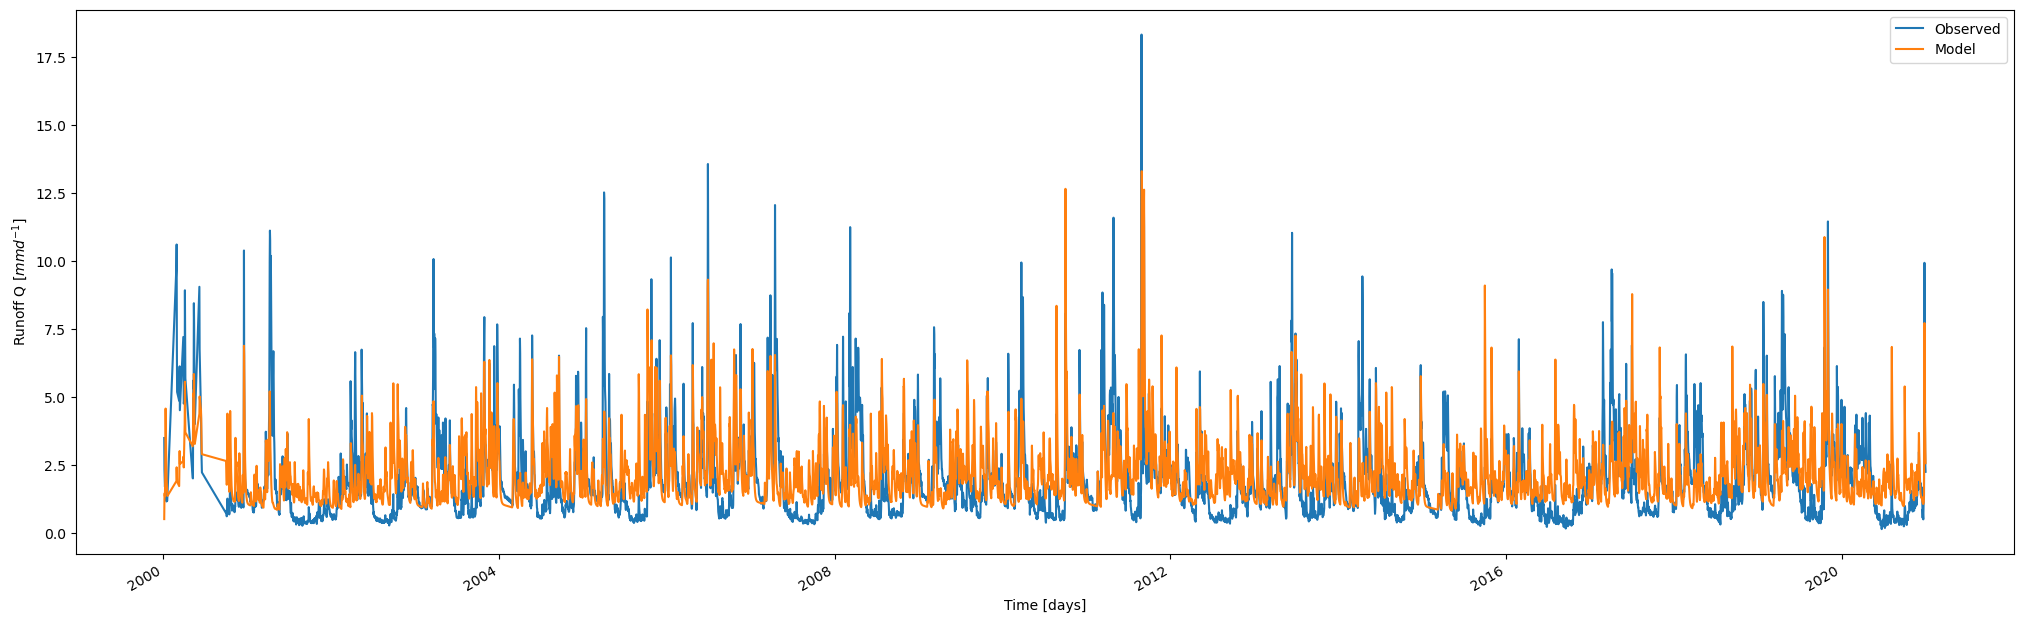

In [10]:
df, Obj, _ = HBVMod(OptPar, df_data_test, OptS, 0, snow=True,  mode='Test')

fig, ax = plt.subplots(figsize=(25,8))
df['Q'].plot(label='Observed', ax=ax)
df['Qm'].plot(label='Model',  ax=ax)
#df['P'].plot(label='P',  ax=ax)
ax.set_xlabel('Time [days]')
ax.set_ylabel('Runoff Q [$mmd^{-1}$]')

ax.legend()


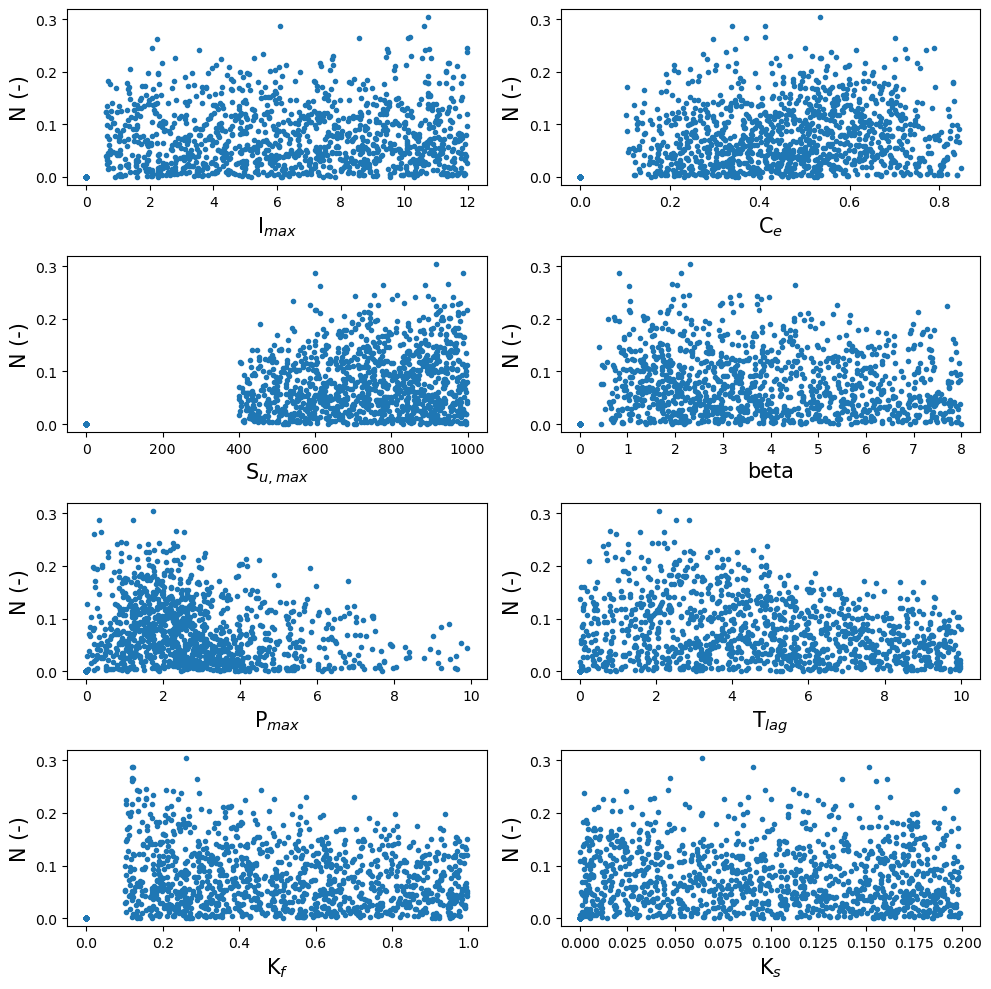

In [11]:
fig, ax = plt.subplots(4,2, figsize=(10,10))


ax[0,0].plot(A[:,0],A[:,8],'.')
ax[0,0].set_xlabel('I$_{max}$', fontsize=15)
ax[0,0].set_ylabel('N (-)', fontsize=15)

plt.subplot(422)
ax[0,1].plot(A[:,1],A[:,8],'.')
ax[0,1].set_xlabel('C$_{e}$', fontsize=15)
ax[0,1].set_ylabel('N (-)', fontsize=15)

plt.subplot(423)
ax[1,0].plot(A[:,2],A[:,8],'.')
ax[1,0].set_xlabel('S$_{u,max}$', fontsize=15)
ax[1,0].set_ylabel('N (-)', fontsize=15), 

plt.subplot(424)
ax[1,1].plot(A[:,3],A[:,8],'.')
ax[1,1].set_xlabel('beta', fontsize=15)
ax[1,1].set_ylabel('N (-)', fontsize=15)

plt.subplot(425)
ax[2,0].plot(A[:,4],A[:,8],'.')
ax[2,0].set_xlabel('P$_{max}$', fontsize=15)
ax[2,0].set_ylabel('N (-)', fontsize=15)

plt.subplot(426)
ax[2,1].plot(A[:,5],A[:,8],'.')
ax[2,1].set_xlabel('T$_{lag}$', fontsize=15)
ax[2,1].set_ylabel('N (-)', fontsize=15)

plt.subplot(427)
ax[3,0].plot(A[:,6],A[:,8],'.')
ax[3,0].set_xlabel('K$_{f}$', fontsize=15)
ax[3,0].set_ylabel('N (-)', fontsize=15)

plt.subplot(428)
ax[3,1].plot(A[:,7],A[:,8],'.')
ax[3,1].set_xlabel('K$_{s}$', fontsize=15)
ax[3,1].set_ylabel('N (-)', fontsize=15)

plt.tight_layout()
plt.show()



In [15]:
fig.savefig(f'Figures\\7000.png')